# Change working directory

In [1]:
%cd ..

/home/minhhieu/Desktop/Hieu/COVIDNet-Implementation


# Import libraries

In [2]:
import os
import tqdm
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model

from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

from dataloader import DataLoader
from contrastive import ArcFace, CosFace, SphereFace
from models import get_small_covid_net

visual_dir = 'media'

checkpoint_dir = 'checkpoints'
model_name = 'covid_net_test_contrastive_arcface_2'

model_path = 'best_model.h5'
weights_path = 'best_model.weights.h5'

test_dir = 'data/covidx/test'
img_size = 480
batch_size = 16

if(not os.path.exists(visual_dir)):
    print('[INFO] Creating visualization directory ...')
    os.mkdir(visual_dir)

# Import model

In [3]:
# Load raw model from weights and model path
model = load_model(os.path.join(checkpoint_dir, model_name, 'models', model_path),
                  custom_objects={'ArcFace' : ArcFace})
model.load_weights(os.path.join(checkpoint_dir, model_name, 'weights', weights_path))

print(model.summary())

Model: "Contrastive_COVID_Net_Small"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 480, 480, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 240, 240, 56) 8288        input_1[0][0]                    
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 240, 240, 56) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 120, 120, 56) 0           re_lu[0][0]                      
________________________________________________________________________

In [4]:
# Get the embedding output only
model = Model(inputs=model.inputs[0], outputs=model.layers[-3].output, 
              name=f'{model.name}_Embedding')

print(model.summary())

Model: "Contrastive_COVID_Net_Small_Embedding"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 480, 480, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 240, 240, 56) 8288        input_1[0][0]                    
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 240, 240, 56) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 120, 120, 56) 0           re_lu[0][0]                      
______________________________________________________________

In [5]:
# Load the baseline model for comparison
baseline = get_small_covid_net(img_size, img_size, 3, batchnorm=False)
baseline.load_weights(os.path.join(checkpoint_dir, 'weights', weights_path))

# Only get the embeddings layer
baseline = Model(inputs=baseline.inputs, outputs=baseline.layers[-2].output, name=f'{baseline.name}_Embedding')

In [6]:
# Load the xception model
xception = load_model(os.path.join(checkpoint_dir, "xception", "xception_classification.h5"))
xception_ = xception
xception = Model(inputs=xception.inputs, outputs=xception.layers[-3].output, name=f'{xception.name}_Embedding')

xception.summary()

Model: "functional_1_Embedding"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
_____________________________________________________________________________

# Test the embedding model

In [7]:
# Load testing data
test_loader = DataLoader(test_dir, labels_as_subdir=True, one_hot=True,
            img_size=img_size,test=True,
            batch_size=batch_size, random_noise=False, )

test_loader2 = DataLoader(test_dir, labels_as_subdir=True, one_hot=True,
            img_size=299,test=True,
            batch_size=batch_size, random_noise=False)

# Get number of batches
test_steps_per_epoch = test_loader.get_train_size()

# Loop through the batches
baseline_embeddings = np.array([])
xception_embeddings = np.array([])
all_embeddings = np.array([])
all_labels = np.array([])

with tqdm.tqdm(total = test_steps_per_epoch) as pbar:
    for batchidx in range(test_steps_per_epoch):
        images, labels = test_loader.get_train_batch()
        images2, labels2 = test_loader2.get_train_batch()
        
        images = images.numpy()
        labels = labels.numpy()
        
        images2 = images2.numpy()
        labels2 = labels2.numpy()
        
        embeddings = model(images, training=False)
        baseline_embds = baseline(images, training=False)
        xception_embds = xception(images, training=False)
        
        if(len(all_embeddings) != 0):
            baseline_embeddings = np.concatenate([baseline_embeddings, baseline_embds])
            all_embeddings = np.concatenate([all_embeddings, embeddings])
            all_labels = np.concatenate([all_labels, labels])
            xception_embeddings = np.concatenate([xception_embeddings, xception_embds])
        else:
            baseline_embeddings = baseline_embds
            all_embeddings = embeddings
            all_labels = labels
            xception_embeddings = xception_embds
        
        pbar.update(1)

100%|██████████| 25/25 [00:23<00:00,  1.06it/s]


# Visualize the result - Contrastive model

[INFO] Silhouette score :  0.40909794


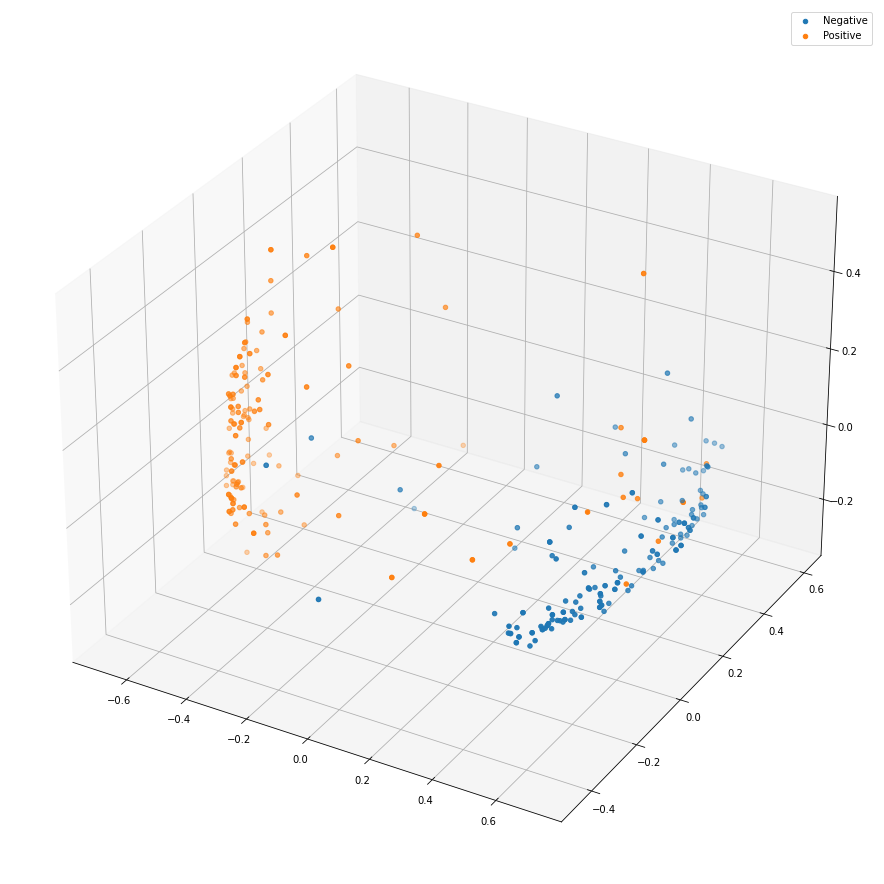

In [11]:
all_categories = np.argmax(all_labels, axis=1)

# Normalize the embeddings and reduce their dimensions using PCA
all_embeddings = all_embeddings / np.linalg.norm(all_embeddings, axis=1).reshape(-1, 1)
embeddings_pca = PCA(n_components=3).fit_transform(all_embeddings)
silhouette = silhouette_score(all_embeddings, all_categories)

fig = plt.figure(figsize=(16, 16))
ax = fig.add_subplot(projection='3d')

for label in np.unique(all_categories):
    cluster = embeddings_pca[all_categories == label]
    
    ax.scatter3D(cluster[:,0], cluster[:, 1], cluster[:,2], label="Negative" if label==0 else "Positive")

    
print('[INFO] Silhouette score : ', silhouette)
plt.legend()
plt.savefig(os.path.join(visual_dir, 'embedding_contrastive_model.png'))
plt.show()

# Visualize the result - Baseline model

[INFO] Silhouette score :  0.16905051


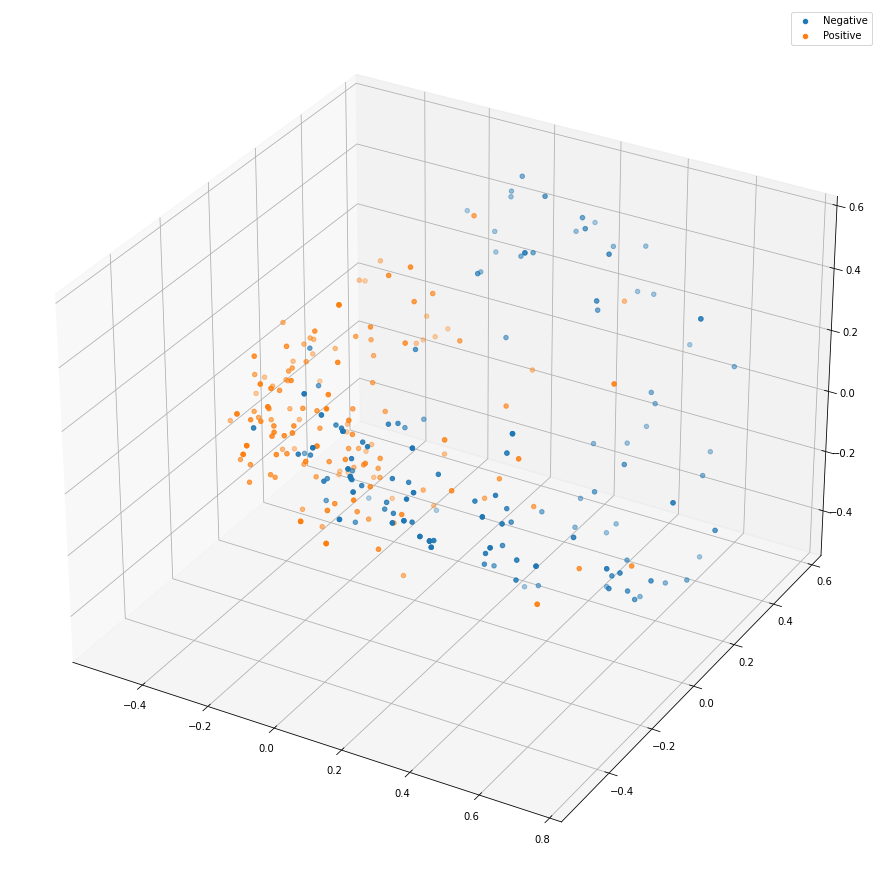

In [12]:
# Normalize the embeddings and reduce their dimensions using PCA
baseline_embeddings = baseline_embeddings / np.linalg.norm(baseline_embeddings, axis=1).reshape(-1, 1)
embeddings_pca = PCA(n_components=3).fit_transform(baseline_embeddings)
silhouette = silhouette_score(baseline_embeddings, all_categories)

fig = plt.figure(figsize=(16, 16))
ax = fig.add_subplot(projection='3d')

for label in np.unique(all_categories):
    cluster = embeddings_pca[all_categories == label]
    
    ax.scatter3D(cluster[:,0], cluster[:, 1], cluster[:,2], label="Negative" if label==0 else "Positive")

print('[INFO] Silhouette score : ', silhouette)
plt.legend()
plt.savefig(os.path.join(visual_dir, 'embedding_baseline_model.png'))
plt.show()

# Visualize the result - Inception Model

[INFO] Silhouette score :  0.024558254


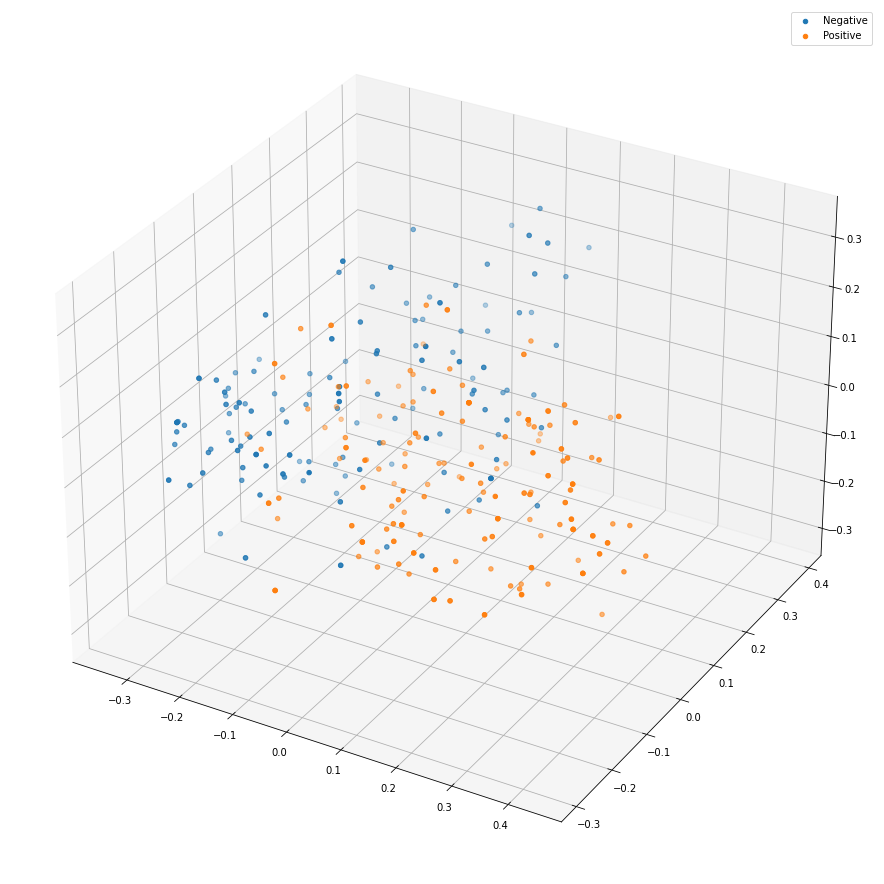

In [13]:
# Normalize the embeddings and reduce their dimensions using PCA
xception_embeddings = xception_embeddings / np.linalg.norm(xception_embeddings, axis=1).reshape(-1, 1)
embeddings_pca = PCA(n_components=3).fit_transform(xception_embeddings)
silhouette = silhouette_score(xception_embeddings, all_categories)

fig = plt.figure(figsize=(16, 16))
ax = fig.add_subplot(projection='3d')

for label in np.unique(all_categories):
    cluster = embeddings_pca[all_categories == label]
    
    ax.scatter3D(cluster[:,0], cluster[:, 1], cluster[:,2], label="Negative" if label==0 else "Positive")

print('[INFO] Silhouette score : ', silhouette)
plt.legend()
plt.savefig(os.path.join(visual_dir, 'xception_model.png'))
plt.show()

In [42]:
from sklearn.metrics import accuracy_score

accuracies = []
for batchidx in range(test_steps_per_epoch):
    images2, labels2 = test_loader2.get_train_batch()

    images2 = ((images2.numpy() * 127.5) + 127.5)/255.0
    labels2 = np.argmax(labels2.numpy(), axis=1)

    predictions = xception_(images2, training=False)
    predictions = np.argmax(predictions, axis=1)
    accuracies.append(accuracy_score(predictions, labels2))

print('Mean accuracy : ', np.array(accuracies).mean())

Mean accuracy :  0.2775
